# Archeological Site Prediction

<p>
    This notebook predicts the locations of archeological sites
    in the neolithic era using different types of machine
    learning models, mostly classification models
</p>

## Import data on site, nonsite, and prediction csvs
may need to drop a few columns

In [1]:
from randomSiteSampling import randomSamplingFromDF

In [2]:
import numpy as np
import pandas as pd
import sklearn as ml
import matplotlib
%matplotlib inline

import pprint
pp = pprint.PrettyPrinter(indent=4).pprint

"""
Importing data
"""
raw_site_file = 'common_sites_V3.csv'
raw_pred_file = 'ireland_sites_V3.csv'

raw_site_df = pd.read_csv(raw_site_file, low_memory=False, error_bad_lines=False, encoding='ISO-8859-1')
raw_pred_df = pd.read_csv(raw_pred_file, low_memory=False, error_bad_lines=False, encoding='ISO-8859-1')

site_df = raw_site_df.copy()
nonsite_df, pred_df = randomSamplingFromDF(raw_site_df, raw_pred_df)

ireland_site_df = site_df.where(site_df['country'] == 'Ireland')

"""
Making sure all dataframes have the same columns
We do this by finding all the columns which are
not shared between all dataframes. We then keep
only the columns common to all the dataframes
"""
site_attr     = set(site_df)
nonsite_attr  = set(nonsite_df)
pred_attr     = set(pred_df)

common_attr   = site_attr & nonsite_attr & pred_attr
uncommon_attr = (site_attr | nonsite_attr | pred_attr) - common_attr

# create list of columns to drop
drop_site     = site_attr    & uncommon_attr
drop_nonsite  = nonsite_attr & uncommon_attr
drop_pred     = pred_attr    & uncommon_attr

# drop columns
site_df       = site_df.drop(columns=drop_site)
nonsite_df    = nonsite_df.drop(columns=drop_nonsite)
pred_df       = pred_df.drop(columns=drop_pred)

"""
Take care of na values by propogating values forward then backward
"""
site_df       = site_df.fillna   (method='ffill').fillna(method='bfill')
nonsite_df    = nonsite_df.fillna(method='ffill').fillna(method='bfill')
pred_df       = pred_df.fillna   (method='ffill').fillna(method='bfill')

# Combining our site and nonsite data

In [3]:
site_df['site'] = 1
nonsite_df['site'] = 0
data = pd.concat([site_df, nonsite_df])

target = data['site']
data = data.drop(columns=['site'])

# Splitting the Data into Training and Test Sets

In [4]:
from sklearn.model_selection import train_test_split

train_size=0.7

train_data, test_data, train_target, test_target = train_test_split(data, target, train_size=train_size)

/Users/WillC/miniconda2/envs/ML/lib/python2.7/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


# Train using Different Models

#### 1. SVC Model (Linear kernel)
#### 2. K-Neighbors Classifier
#### 4. Decision Forest Classifier
#### 4. Random Forest Classifier
#### 5. Gradient Boosting Classifier
#### 6. Ada Boosting Classifier

### The 'predictions' dataframe will be used  to store the results of the following training models

In [5]:
predictions = pred_df.copy(deep=True)

In [6]:
from plotPredicted import plotPredictedFromDF

## 1. Linear SVC Model

#### Training the Linear SVC Model

In [7]:
from sklearn import svm

SVCModel = svm.SVC(kernel='linear', C=.5)
SVCModel.fit(train_data, train_target)

SVC(C=0.5, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

#### Testing the Linear SVC Model

In [8]:
from sklearn import metrics

model = SVCModel
"""
Fit the training data
and observe the metrics
"""
preds = model.predict(train_data)
targs = train_target
args = (targs, preds)
print "Training Data"
print "accuracy  : %.03f%s" % (metrics.accuracy_score(*args)*100, "%")
print "precision : %.03f%s" % (metrics.precision_score(*args)*100, "%")
print "recall    : %.03f%s" % (metrics.recall_score(*args)*100, "%")
print "f1        : %.03f%s" % (metrics.f1_score(*args)*100, "%")

"""
Fit the test data
and observe the metrics
"""
preds = model.predict(test_data)
targs = test_target
args = (targs, preds)
print "\n"
print "Test Data"
print "accuracy  : %.03f%s" % (metrics.accuracy_score(*args)*100, "%")
print "precision : %.03f%s" % (metrics.precision_score(*args)*100, "%")
print "recall    : %.03f%s" % (metrics.recall_score(*args)*100, "%")
print "f1        : %.03f%s" % (metrics.f1_score(*args)*100, "%")

Training Data
accuracy  : 84.713%
precision : 93.526%
recall    : 75.046%
f1        : 83.273%


Test Data
accuracy  : 83.991%
precision : 90.859%
recall    : 74.376%
f1        : 81.796%


#### Linear SVC Prediction

Sites exists         : 40491 
Sites does not exists: 618446 
Percentage of sites predicted having an archeological site: 6.145%


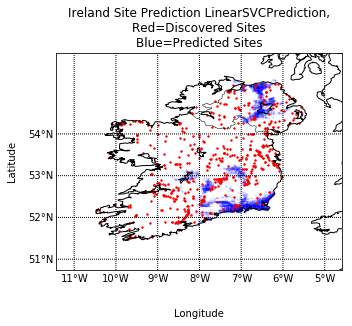

In [43]:
model_name = 'LinearSVCPrediction'
predictions[model_name] = SVCModel.predict(pred_df)

site_exists = predictions[predictions[model_name] == 1]
site_nexists = predictions[predictions[model_name] != 1]
num_site_exists = site_exists[model_name].count()
num_site_nexists = site_nexists[model_name].count()

print 'Sites exists         : %d ' % (num_site_exists)
print 'Sites does not exists: %d ' % (num_site_nexists)
print 'Percentage of sites predicted having an archeological site: %.3f%s' % \
(100.0*float(num_site_exists)/float(num_site_exists+num_site_nexists), '%')

# plot the map
plotPredictedFromDF(raw_site_df, 
                    predictions, 
                    model_name=model_name, 
                    country='Ireland', 
                    resolution='i',
                    alpha_predicted=.01)

## 2. K-Neighbors Classifier

#### Training the K-Neighbors Classifier Model

In [21]:
from sklearn import neighbors

n_neighbors=20
KNeighborsModel = neighbors.KNeighborsClassifier(n_neighbors=n_neighbors)
KNeighborsModel.fit(train_data, train_target)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=20, p=2,
           weights='uniform')

#### Testing the K-Neighbors Classifier Model

In [22]:
from sklearn import metrics

model = KNeighborsModel
"""
Fit the training data
and observe the metrics
"""
preds = model.predict(train_data)
targs = train_target
args = (targs, preds)
print "Training Data"
print "accuracy  : %.03f%s" % (metrics.accuracy_score(*args)*100, "%")
print "precision : %.03f%s" % (metrics.precision_score(*args)*100, "%")
print "recall    : %.03f%s" % (metrics.recall_score(*args)*100, "%")
print "f1        : %.03f%s" % (metrics.f1_score(*args)*100, "%")

"""
Fit the test data
and observe the metrics
"""
preds = model.predict(test_data)
targs = test_target
args = (targs, preds)
print "\n"
print "Test Data"
print "accuracy  : %.03f%s" % (metrics.accuracy_score(*args)*100, "%")
print "precision : %.03f%s" % (metrics.precision_score(*args)*100, "%")
print "recall    : %.03f%s" % (metrics.recall_score(*args)*100, "%")
print "f1        : %.03f%s" % (metrics.f1_score(*args)*100, "%")

Training Data
accuracy  : 84.760%
precision : 97.243%
recall    : 71.985%
f1        : 82.729%


Test Data
accuracy  : 84.649%
precision : 96.308%
recall    : 70.975%
f1        : 81.723%


#### K-Neighbors Prediction

Sites exists         : 15240 
Sites does not exists: 643697 
Percentage of sites predicted having an archeological site
Percentage of sites predicted having an archeological site: 2.313%


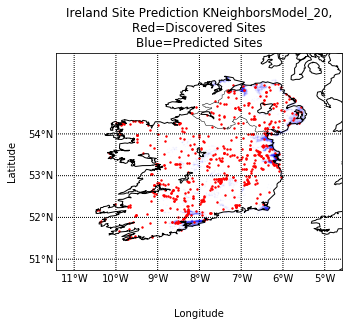

In [42]:
model_name = 'KNeighborsModel_%d' % n_neighbors
predictions[model_name] = KNeighborsModel.predict(pred_df)

site_exists      = predictions[predictions[model_name] == 1]
site_nexists     = predictions[predictions[model_name] != 1]
num_site_exists  = site_exists[model_name].count()
num_site_nexists = site_nexists[model_name].count()

print 'Sites exists         : %d ' % (num_site_exists)
print 'Sites does not exists: %d ' % (num_site_nexists)
print 'Percentage of sites predicted having an archeological site'
print 'Percentage of sites predicted having an archeological site: %.3f%s' % \
(100.0*float(num_site_exists)/float(num_site_exists+num_site_nexists), '%')

# plot the map
plotPredictedFromDF(raw_site_df, 
                    predictions, 
                    model_name=model_name, 
                    country='Ireland', 
                    resolution='i',
                    alpha_predicted=.01)

## 3. Decision Tree Classification

In [25]:
from sklearn import tree

DecisionTree = tree.DecisionTreeClassifier()
DecisionTree.fit(train_data, train_target)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

#### Testing the Decision Tree Classifier Model

In [26]:
from sklearn import metrics

model = DecisionTree
"""
Fit the training data
and observe the metrics
"""
preds = model.predict(train_data)
targs = train_target
args = (targs, preds)
print "Training Data"
print "accuracy  : %.03f%s" % (metrics.accuracy_score(*args)*100, "%")
print "precision : %.03f%s" % (metrics.precision_score(*args)*100, "%")
print "recall    : %.03f%s" % (metrics.recall_score(*args)*100, "%")
print "f1        : %.03f%s" % (metrics.f1_score(*args)*100, "%")

"""
Fit the test data
and observe the metrics
"""
preds = model.predict(test_data)
targs = test_target
args = (targs, preds)
print "\n"
print "Test Data"
print "accuracy  : %.03f%s" % (metrics.accuracy_score(*args)*100, "%")
print "precision : %.03f%s" % (metrics.precision_score(*args)*100, "%")
print "recall    : %.03f%s" % (metrics.recall_score(*args)*100, "%")
print "f1        : %.03f%s" % (metrics.f1_score(*args)*100, "%")

Training Data
accuracy  : 100.000%
precision : 100.000%
recall    : 100.000%
f1        : 100.000%


Test Data
accuracy  : 93.311%
precision : 92.411%
recall    : 93.878%
f1        : 93.138%


#### Decision Tree Prediction

Sites exists         : 51006 
Sites does not exists: 607931 
Percentage of sites predicted having an archeological site
Percentage of sites predicted having an archeological site: 7.741%


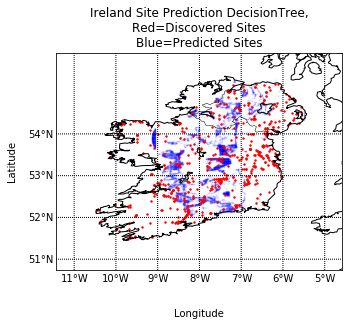

In [38]:
model_name = 'DecisionTree'
predictions[model_name] = DecisionTree.predict(pred_df)

site_exists      = predictions[predictions[model_name] == 1]
site_nexists     = predictions[predictions[model_name] != 1]
num_site_exists  = site_exists[model_name].count()
num_site_nexists = site_nexists[model_name].count()

print 'Sites exists         : %d ' % (num_site_exists)
print 'Sites does not exists: %d ' % (num_site_nexists)
print 'Percentage of sites predicted having an archeological site'
print 'Percentage of sites predicted having an archeological site: %.3f%s' % \
(100.0*float(num_site_exists)/float(num_site_exists+num_site_nexists), '%')

# plot the map
plotPredictedFromDF(raw_site_df, 
                    predictions, 
                    model_name=model_name, 
                    country='Ireland', 
                    resolution='i',
                    alpha_predicted=.01)

## 4. Random Forest Classification

In [28]:
from sklearn import ensemble

n_estimators=10
RandomForest = ensemble.RandomForestClassifier(n_estimators=10)
RandomForest.fit(train_data, train_target)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

#### Testing the Random Forest Classifier Model

In [29]:
from sklearn import metrics

model = RandomForest
"""
Fit the training data
and observe the metrics
"""
preds = model.predict(train_data)
targs = train_target
args = (targs, preds)
print "Training Data"
print "accuracy  : %.03f%s" % (metrics.accuracy_score(*args)*100, "%")
print "precision : %.03f%s" % (metrics.precision_score(*args)*100, "%")
print "recall    : %.03f%s" % (metrics.recall_score(*args)*100, "%")
print "f1        : %.03f%s" % (metrics.f1_score(*args)*100, "%")

"""
Fit the test data
and observe the metrics
"""
preds = model.predict(test_data)
targs = test_target
args = (targs, preds)
print "\n"
print "Test Data"
print "accuracy  : %.03f%s" % (metrics.accuracy_score(*args)*100, "%")
print "precision : %.03f%s" % (metrics.precision_score(*args)*100, "%")
print "recall    : %.03f%s" % (metrics.recall_score(*args)*100, "%")
print "f1        : %.03f%s" % (metrics.f1_score(*args)*100, "%")

Training Data
accuracy  : 99.577%
precision : 100.000%
recall    : 99.165%
f1        : 99.581%


Test Data
accuracy  : 93.969%
precision : 98.010%
recall    : 89.342%
f1        : 93.476%


#### Random Forest Prediction

Sites exists         : 11342 
Sites does not exists: 647595 
Percentage of sites predicted having an archeological site
Percentage of sites predicted having an archeological site: 1.721%


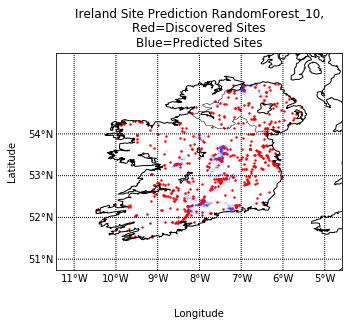

In [39]:
model_name = 'RandomForest_%d' % (n_estimators)
predictions[model_name] = RandomForest.predict(pred_df)

site_exists      = predictions[predictions[model_name] == 1]
site_nexists     = predictions[predictions[model_name] != 1]
num_site_exists  = site_exists[model_name].count()
num_site_nexists = site_nexists[model_name].count()

print 'Sites exists         : %d ' % (num_site_exists)
print 'Sites does not exists: %d ' % (num_site_nexists)
print 'Percentage of sites predicted having an archeological site'
print 'Percentage of sites predicted having an archeological site: %.3f%s' % \
(100.0*float(num_site_exists)/float(num_site_exists+num_site_nexists), '%')

# plot the map
plotPredictedFromDF(raw_site_df, 
                    predictions, 
                    model_name=model_name, 
                    country='Ireland', 
                    resolution='i',
                    alpha_predicted=.01)

## 5. Gradient Boosting Classification

In [31]:
from sklearn import ensemble

GradientBoosting = ensemble.GradientBoostingClassifier()
GradientBoosting.fit(train_data, train_target)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)

#### Testing the Gradient Boosting Classifier

In [32]:
from sklearn import metrics

model = GradientBoosting
"""
Fit the training data
and observe the metrics
"""
preds = model.predict(train_data)
targs = train_target
args = (targs, preds)
print "Training Data"
print "accuracy  : %.03f%s" % (metrics.accuracy_score(*args)*100, "%")
print "precision : %.03f%s" % (metrics.precision_score(*args)*100, "%")
print "recall    : %.03f%s" % (metrics.recall_score(*args)*100, "%")
print "f1        : %.03f%s" % (metrics.f1_score(*args)*100, "%")

"""
Fit the test data
and observe the metrics
"""
preds = model.predict(test_data)
targs = test_target
args = (targs, preds)
print "\n"
print "Test Data"
print "accuracy  : %.03f%s" % (metrics.accuracy_score(*args)*100, "%")
print "precision : %.03f%s" % (metrics.precision_score(*args)*100, "%")
print "recall    : %.03f%s" % (metrics.recall_score(*args)*100, "%")
print "f1        : %.03f%s" % (metrics.f1_score(*args)*100, "%")

Training Data
accuracy  : 97.131%
precision : 100.000%
recall    : 94.341%
f1        : 97.088%


Test Data
accuracy  : 95.504%
precision : 98.780%
recall    : 91.837%
f1        : 95.182%


#### Gradient Boosting Classifier Prediction

Sites exists         : 8044 
Sites does not exists: 650893 
Percentage of sites predicted having an archeological site:
Percentage of sites predicted having an archeological site: 1.221%


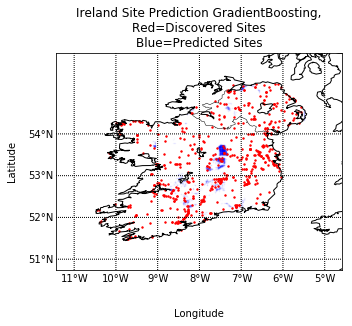

In [40]:
model_name = 'GradientBoosting'
predictions[model_name] = GradientBoosting.predict(pred_df)

site_exists      = predictions[predictions[model_name] == 1]
site_nexists     = predictions[predictions[model_name] != 1]
num_site_exists  = site_exists[model_name].count()
num_site_nexists = site_nexists[model_name].count()

print 'Sites exists         : %d ' % (num_site_exists)
print 'Sites does not exists: %d ' % (num_site_nexists)
print 'Percentage of sites predicted having an archeological site:'
print 'Percentage of sites predicted having an archeological site: %.3f%s' % \
(100.0*float(num_site_exists)/float(num_site_exists+num_site_nexists), '%')

# plot the map
plotPredictedFromDF(raw_site_df, 
                    predictions, 
                    model_name=model_name, 
                    country='Ireland', 
                    resolution='i',
                    alpha_predicted=.01)

## 6. Ada Boosting Classification

In [35]:
from sklearn import ensemble

AdaBoosting = ensemble.AdaBoostClassifier()
AdaBoosting.fit(train_data, train_target)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None)

#### Testing the Ada Boosting Classification

In [36]:
from sklearn import metrics

model = AdaBoosting
"""
Fit the training data
and observe the metrics
"""
preds = model.predict(train_data)
targs = train_target
args = (targs, preds)
print "Training Data"
print "accuracy  : %.03f%s" % (metrics.accuracy_score(*args)*100, "%")
print "precision : %.03f%s" % (metrics.precision_score(*args)*100, "%")
print "recall    : %.03f%s" % (metrics.recall_score(*args)*100, "%")
print "f1        : %.03f%s" % (metrics.f1_score(*args)*100, "%")

"""
Fit the test data
and observe the metrics
"""
preds = model.predict(test_data)
targs = test_target
args = (targs, preds)
print "\n"
print "Test Data"
print "accuracy  : %.03f%s" % (metrics.accuracy_score(*args)*100, "%")
print "precision : %.03f%s" % (metrics.precision_score(*args)*100, "%")
print "recall    : %.03f%s" % (metrics.recall_score(*args)*100, "%")
print "f1        : %.03f%s" % (metrics.f1_score(*args)*100, "%")

Training Data
accuracy  : 95.296%
precision : 98.225%
recall    : 92.393%
f1        : 95.220%


Test Data
accuracy  : 91.776%
precision : 92.558%
recall    : 90.249%
f1        : 91.389%


#### Ada Boosting Prediction

Sites exists         : 34408 
Sites does not exists: 624529 
Percentage of sites predicted having an archeological site: 5.222%


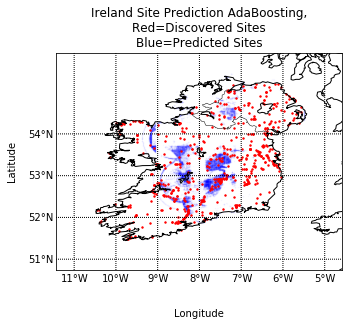

In [41]:
model_name = 'AdaBoosting'
predictions[model_name] = AdaBoosting.predict(pred_df)

site_exists      = predictions[predictions[model_name] == 1]
site_nexists     = predictions[predictions[model_name] != 1]
num_site_exists  = site_exists[model_name].count()
num_site_nexists = site_nexists[model_name].count()

print 'Sites exists         : %d ' % (num_site_exists)
print 'Sites does not exists: %d ' % (num_site_nexists)
print 'Percentage of sites predicted having an archeological site: %.3f%s' % \
(100.0*float(num_site_exists)/float(num_site_exists+num_site_nexists), '%')

# plot the map
plotPredictedFromDF(raw_site_df, 
                    predictions, 
                    model_name=model_name, 
                    country='Ireland', 
                    resolution='i',
                    alpha_predicted=.01)